In [9]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.7 MB/s eta 0:00:00


In [11]:
import pandas as pd
df = pd.read_csv("diabetes.csv")
df.dropna()
df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [12]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [13]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_df = scaler.fit_transform(df)
df = pd.DataFrame(normalized_df, columns=df.columns)

df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,0.483333,1.0
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,0.166667,0.0
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,0.183333,1.0
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,0.000000,0.0
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,0.200000,1.0


In [14]:
from sklearn.model_selection import train_test_split
X=df.drop(['Outcome'],axis=1)
y=df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

In [36]:
from sklearn.neighbors import NearestNeighbors
from math import sqrt, pi, exp

class KNN:
    def __init__(
        self,
        fixed_wt: bool,
        kernel: str,
        metric: str,
        h: int | None = None,
        n_neighbors: int | None = 5
    ):
        self.h = h
        self.radius = None
        self.fixed = fixed_wt
        if fixed_wt:
            self.n_neighbors = h
            self.radius = h
        else:
            self.n_neighbors = n_neighbors + 1
            self.radius = n_neighbors
        self.kernel = kernel
        self.metric = metric

    def fit(self, X, y, weights = None):
        self.X_train = X
        self.y_train = y
        self.categories_count = len(set(y))
        self.weights = weights if weights is not None else np.ones(len(self.y_train))
        return self

    def predict(self, X):
        nn = NearestNeighbors(n_neighbors=self.n_neighbors, metric=self.metric).fit(self.X_train)
        if self.fixed:
            distances, indexes = nn.radius_neighbors(X, self.radius)
        else:
            distances, indexes = nn.kneighbors(X, n_neighbors=self.n_neighbors)
        categories, weights = [], []
        for i in indexes:
            categories.append([int(_) for _ in self.y_train.iloc[i].tolist()])
            weights.append([self.weights[_] for _ in i])
        prediction = []
        for obj in range(len(X)):
            dist, cls, w = distances[obj], categories[obj], weights[obj]
            scores = np.zeros(self.categories_count).tolist()
            if self.radius:
                radius = self.radius
                l = len(dist)
            else:
                l = len(dist)-1
                radius = dist[-1]
            for i in range(l):
                scores[cls[i]] += self.count_kernel(dist[i] / radius) * w[i]
            prediction.append(scores.index(max(scores)))
        return pd.Series(prediction)

    def count_kernel(self, x):
        match self.kernel:
            case 'uniform':
                return uniform(x)
            case 'epanechnikov':
                return epanechnikov(x)
            case 'triangular':
                return triangular(x)
            case 'gaussian':
                return gaussian(x)
            case _:
                return 0

def uniform(x):
    return 0.5 if -1<x<1 else 0
def epanechnikov(x):
    return max(0, 0.75 * (1 - x**2))
def triangular(x):
    return max(0, 1 - abs(x))
def gaussian(x):
    return (1 / sqrt(2*pi)) * exp(-(x**2/2))


\\

In [37]:
from sklearn.metrics import accuracy_score
knn = KNN(fixed_wt=False, n_neighbors=5, kernel='triangular', metric='manhattan')
model = knn.fit(X_train, y_train)
prediction = model.predict(X_test)

accuracy_score(y_test, prediction)


0.7359307359307359

In [26]:
knn = KNN(fixed_wt=True, h=5, kernel='triangular', metric='manhattan')
model = knn.fit(X_train, y_train)
prediction = model.predict(X_test)

accuracy_score(y_test, prediction)

0.6883116883116883

In [27]:
def optimize(fixed, trial):
    pred = KNN(
        h=trial.suggest_int("h", 1, 100),
        n_neighbors=trial.suggest_int("n", 1, 100),
        fixed_wt=fixed,
        kernel=trial.suggest_categorical('kernel', ['uniform', "epanechnikov", 'triangular', 'gaussian']),
        metric=trial.suggest_categorical('metric', ['manhattan', 'euclidean', 'cosine'])
    ).fit(X_train, y_train).predict(X_test)

    return accuracy_score(y_test, pred)

import optuna
study = optuna.create_study(direction="maximize")
study.optimize(lambda t: optimize(False, t), n_trials=100)
study.optimize(lambda t: optimize(True, t), n_trials=100)


[I 2024-09-12 16:16:25,627] A new study created in memory with name: no-name-e4b52dcb-f3c3-4fd8-8495-0328b0d376a2
[I 2024-09-12 16:16:25,697] Trial 0 finished with value: 0.7748917748917749 and parameters: {'h': 2, 'n': 60, 'kernel': 'epanechnikov', 'metric': 'euclidean'}. Best is trial 0 with value: 0.7748917748917749.
[I 2024-09-12 16:16:25,772] Trial 1 finished with value: 0.7662337662337663 and parameters: {'h': 13, 'n': 61, 'kernel': 'gaussian', 'metric': 'manhattan'}. Best is trial 0 with value: 0.7748917748917749.
[I 2024-09-12 16:16:25,815] Trial 2 finished with value: 0.7489177489177489 and parameters: {'h': 64, 'n': 17, 'kernel': 'gaussian', 'metric': 'manhattan'}. Best is trial 0 with value: 0.7748917748917749.
[I 2024-09-12 16:16:25,889] Trial 3 finished with value: 0.7835497835497836 and parameters: {'h': 85, 'n': 82, 'kernel': 'epanechnikov', 'metric': 'euclidean'}. Best is trial 3 with value: 0.7835497835497836.
[I 2024-09-12 16:16:25,967] Trial 4 finished with value: 0.

In [ ]:
print(study.best_value)
print(study.best_trial)

0.7878787878787878
FrozenTrial(number=6, state=TrialState.COMPLETE, values=[0.7878787878787878], datetime_start=datetime.datetime(2024, 9, 12, 12, 33, 26, 751886), datetime_complete=datetime.datetime(2024, 9, 12, 12, 33, 26, 795568), params={'h': 63, 'n': 47, 'kernel': 'triangular', 'metric': 'euclidean'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'h': IntDistribution(high=100, log=False, low=1, step=1), 'n': IntDistribution(high=100, log=False, low=1, step=1), 'kernel': CategoricalDistribution(choices=('uniform', 'epanechnikov', 'triangular', 'gaussian')), 'metric': CategoricalDistribution(choices=('manhattan', 'euclidean', 'cosine'))}, trial_id=6, value=None)


In [28]:
from sklearn.neighbors import KNeighborsClassifier
def optimize_lib(trial):
    pred = KNeighborsClassifier(
        n_neighbors=trial.suggest_int("n", 1, 100),
        weights=trial.suggest_categorical("weights", ["uniform", "distance"]),
        metric=trial.suggest_categorical('metric', ['manhattan', 'euclidean', 'cosine'])
    ).fit(X_train, y_train).predict(X_test)
    return accuracy_score(y_test, pred)

study = optuna.create_study(direction="maximize")
study.optimize(optimize_lib, n_trials=100)

[I 2024-09-12 16:17:17,384] A new study created in memory with name: no-name-1e0b5128-59f3-429f-8c62-e3fec7ff5b9d
[I 2024-09-12 16:17:17,406] Trial 0 finished with value: 0.7359307359307359 and parameters: {'n': 18, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 0 with value: 0.7359307359307359.
[I 2024-09-12 16:17:17,425] Trial 1 finished with value: 0.7619047619047619 and parameters: {'n': 67, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 1 with value: 0.7619047619047619.
[I 2024-09-12 16:17:17,447] Trial 2 finished with value: 0.7619047619047619 and parameters: {'n': 56, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 1 with value: 0.7619047619047619.
[I 2024-09-12 16:17:17,471] Trial 3 finished with value: 0.7532467532467533 and parameters: {'n': 48, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 1 with value: 0.7619047619047619.
[I 2024-09-12 16:17:17,510] Trial 4 finished with value: 0.6796536796536796 and parameters: {'n': 

In [29]:
print(study.best_value)
print(study.best_trial)

0.7878787878787878
FrozenTrial(number=65, state=TrialState.COMPLETE, values=[0.7878787878787878], datetime_start=datetime.datetime(2024, 9, 12, 16, 17, 20, 445575), datetime_complete=datetime.datetime(2024, 9, 12, 16, 17, 20, 484612), params={'n': 77, 'weights': 'uniform', 'metric': 'manhattan'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n': IntDistribution(high=100, log=False, low=1, step=1), 'weights': CategoricalDistribution(choices=('uniform', 'distance')), 'metric': CategoricalDistribution(choices=('manhattan', 'euclidean', 'cosine'))}, trial_id=65, value=None)


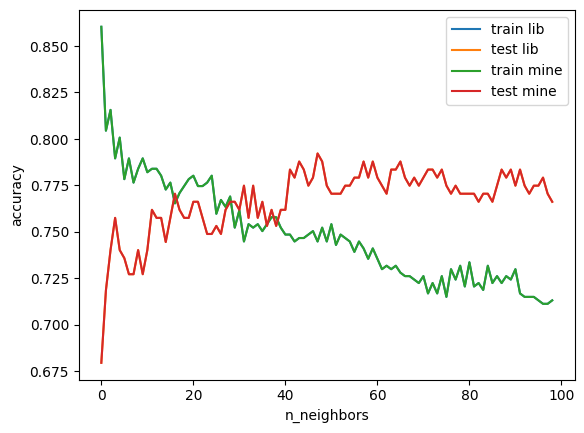

In [30]:
from matplotlib import pyplot as plt

def my_knn(n, X, y):
    return accuracy_score(KNN(n_neighbors=n, fixed_wt=False, kernel='uniform', metric='euclidean').fit(X_train, y_train).predict(X), y)
def lib_knn(n, X, y):
    return accuracy_score(KNeighborsClassifier(n_neighbors=n, weights='uniform', metric='euclidean').fit(X_train, y_train).predict(X), y)

lib_train = []
lib_test = []
my_train = []
my_test = []

for k in range(1, 100):
    lib_train.append(my_knn(k, X_train, y_train))
    lib_test.append(lib_knn(k, X_test, y_test))
    my_train.append(my_knn(k, X_train, y_train))
    my_test.append(lib_knn(k, X_test, y_test))

plt.plot(lib_train, label='train lib')
plt.plot(lib_test, label='test lib')
plt.plot(my_train, label='train mine')
plt.plot(my_test, label='test mine')
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('accuracy')
plt.show()

In [39]:
def lowess(X, y, knn):
    X = X.to_numpy()
    y = y.to_numpy()
    weights = []
    for i in range(len(X)):
        r = knn.fit(np.delete(X, i, axis=0), np.delete(y, i, axis=0)).predict(np.array([X[i]]))[0]
        weights.append(1 if y[i] == r else 0)
    return weights
prior_weights = lowess(X_train, y_train, KNeighborsClassifier(n_neighbors=3))

accuracy_score(KNN(n_neighbors=6, fixed_wt=False, kernel='uniform', metric='euclidean').fit(X_train, y_train, prior_weights).predict(X_test), y_test)

0.7445887445887446